In [27]:
#Installing tensorflow 2.9.1 version
!pip install tensorflow==2.9.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 81.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 82.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 55.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.5.26
    Uninstalling flatbuffers-23.5.26:
      Successfully uninstalled flatbuffers-23.5.26
  Attempting uninstall: tensorfl

In [1]:
#Upload kaggle dataset directly in google colab
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


In [2]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

100% 2.04G/2.04G [01:41<00:00, 22.9MB/s]
100% 2.04G/2.04G [01:41<00:00, 21.6MB/s]


In [3]:
#Extract zip files - plantvillage dataset
import zipfile
zip_ref = zipfile.ZipFile('/content/plantvillage-dataset.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [1]:
#import modules
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
import tensorflow as tf
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as py
from keras.applications.resnet_v2 import ResNet152V2
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.inception_v3 import InceptionV3
from keras.applications.efficientnet import EfficientNetB3,preprocess_input
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img,img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras import regularizers
import numpy as np
from glob import glob
import pandas as p
import os
import cv2
from keras.models import load_model
import shutil
from sklearn.model_selection import train_test_split
# from PIL import image
from sklearn.metrics import accuracy_score

In [5]:
# Functions to Create Data Frame from Dataset
# Generate data paths with labels
def define_paths(img_dir):
    filepaths = [] #creating empty list
    labels = []

    folds = os.listdir(img_dir) # list directories inside img_dir
    for fold in folds:
        foldpath = os.path.join(img_dir, fold) #concatenate each dir inside img_dir with img_dir and storing them in foldpath
        filelist = os.listdir(foldpath) #now access image files
        for files_l in filelist:
            fpath = os.path.join(foldpath, files_l)
            filepaths.append(fpath) #append those image directories in filepaths
            labels.append(fold)# append folder name which are their corresponding label

    return filepaths, labels

# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    F = p.Series(files, name= 'file_dir') #creating series of file paths
    L = p.Series(classes, name='labels') #creating series of labels
    return p.concat([F, L], axis= 1)

# Split dataframe to train, valid, and test
def split_data(img_dir):
    # train dataframe
    files, classes = define_paths(img_dir) #calling define_paths function which will return file_paths and labels
    df = define_df(files, classes) #calling define_df function
    strat = df['labels'] #using stratify to uniformly distribute instances of classes in both dataframe , i.e. train and dummy to prevent model from getting biased towards any particular class.
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # valid and test dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

In [6]:
'''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''
def create_gens (train_df, valid_df, test_df, batch_size):

    img_size = (300, 300) # setting it according to image size used in pretrained model
    channels = 3
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels) #defines that image has 300 X 300 pixels dimension and RGB system


    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))

    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'file_dir', y_col= 'labels', target_size= img_size, class_mode= 'sparse',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'file_dir', y_col= 'labels', target_size= img_size, class_mode= 'sparse',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'file_dir', y_col= 'labels', target_size= img_size, class_mode= 'sparse',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

In [7]:
def show_images(gen):

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    py.figure(figsize= (20, 20))

    for i in range(sample):
        py.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        py.imshow(image)
        index = int(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        py.title(class_name, color= 'black', fontsize= 8)
        py.axis('off')
    py.show()

In [8]:
data_dir = '/content/plantvillage dataset/segmented'

try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(data_dir)

    # Get Generators
    batch_size = 40
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except Exception as e:
    print('Error:', e)

Found 43444 validated image filenames belonging to 38 classes.
Found 5431 validated image filenames belonging to 38 classes.
Found 5431 validated image filenames belonging to 38 classes.


In [9]:
train_gen[0]

(array([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],
 
 
        [

In [10]:
train_df

,file_dir,labels
25500,/content/plantvillage dataset/segmented/Pepper...,"Pepper,_bell___healthy"
251,/content/plantvillage dataset/segmented/Bluebe...,Blueberry___healthy
39504,/content/plantvillage dataset/segmented/Soybea...,Soybean___healthy
49822,/content/plantvillage dataset/segmented/Tomato...,Tomato___Leaf_Mold
16452,/content/plantvillage dataset/segmented/Orange...,Orange___Haunglongbing_(Citrus_greening)
...,...,...
18007,/content/plantvillage dataset/segmented/Orange...,Orange___Haunglongbing_(Citrus_greening)
20988,/content/plantvillage dataset/segmented/Orange...,Orange___Haunglongbing_(Citrus_greening)
54069,/content/plantvillage dataset/segmented/Raspbe...,Raspberry___healthy
22323,/content/plantvillage dataset/segmented/Pepper...,"Pepper,_bell___Bacterial_spot"


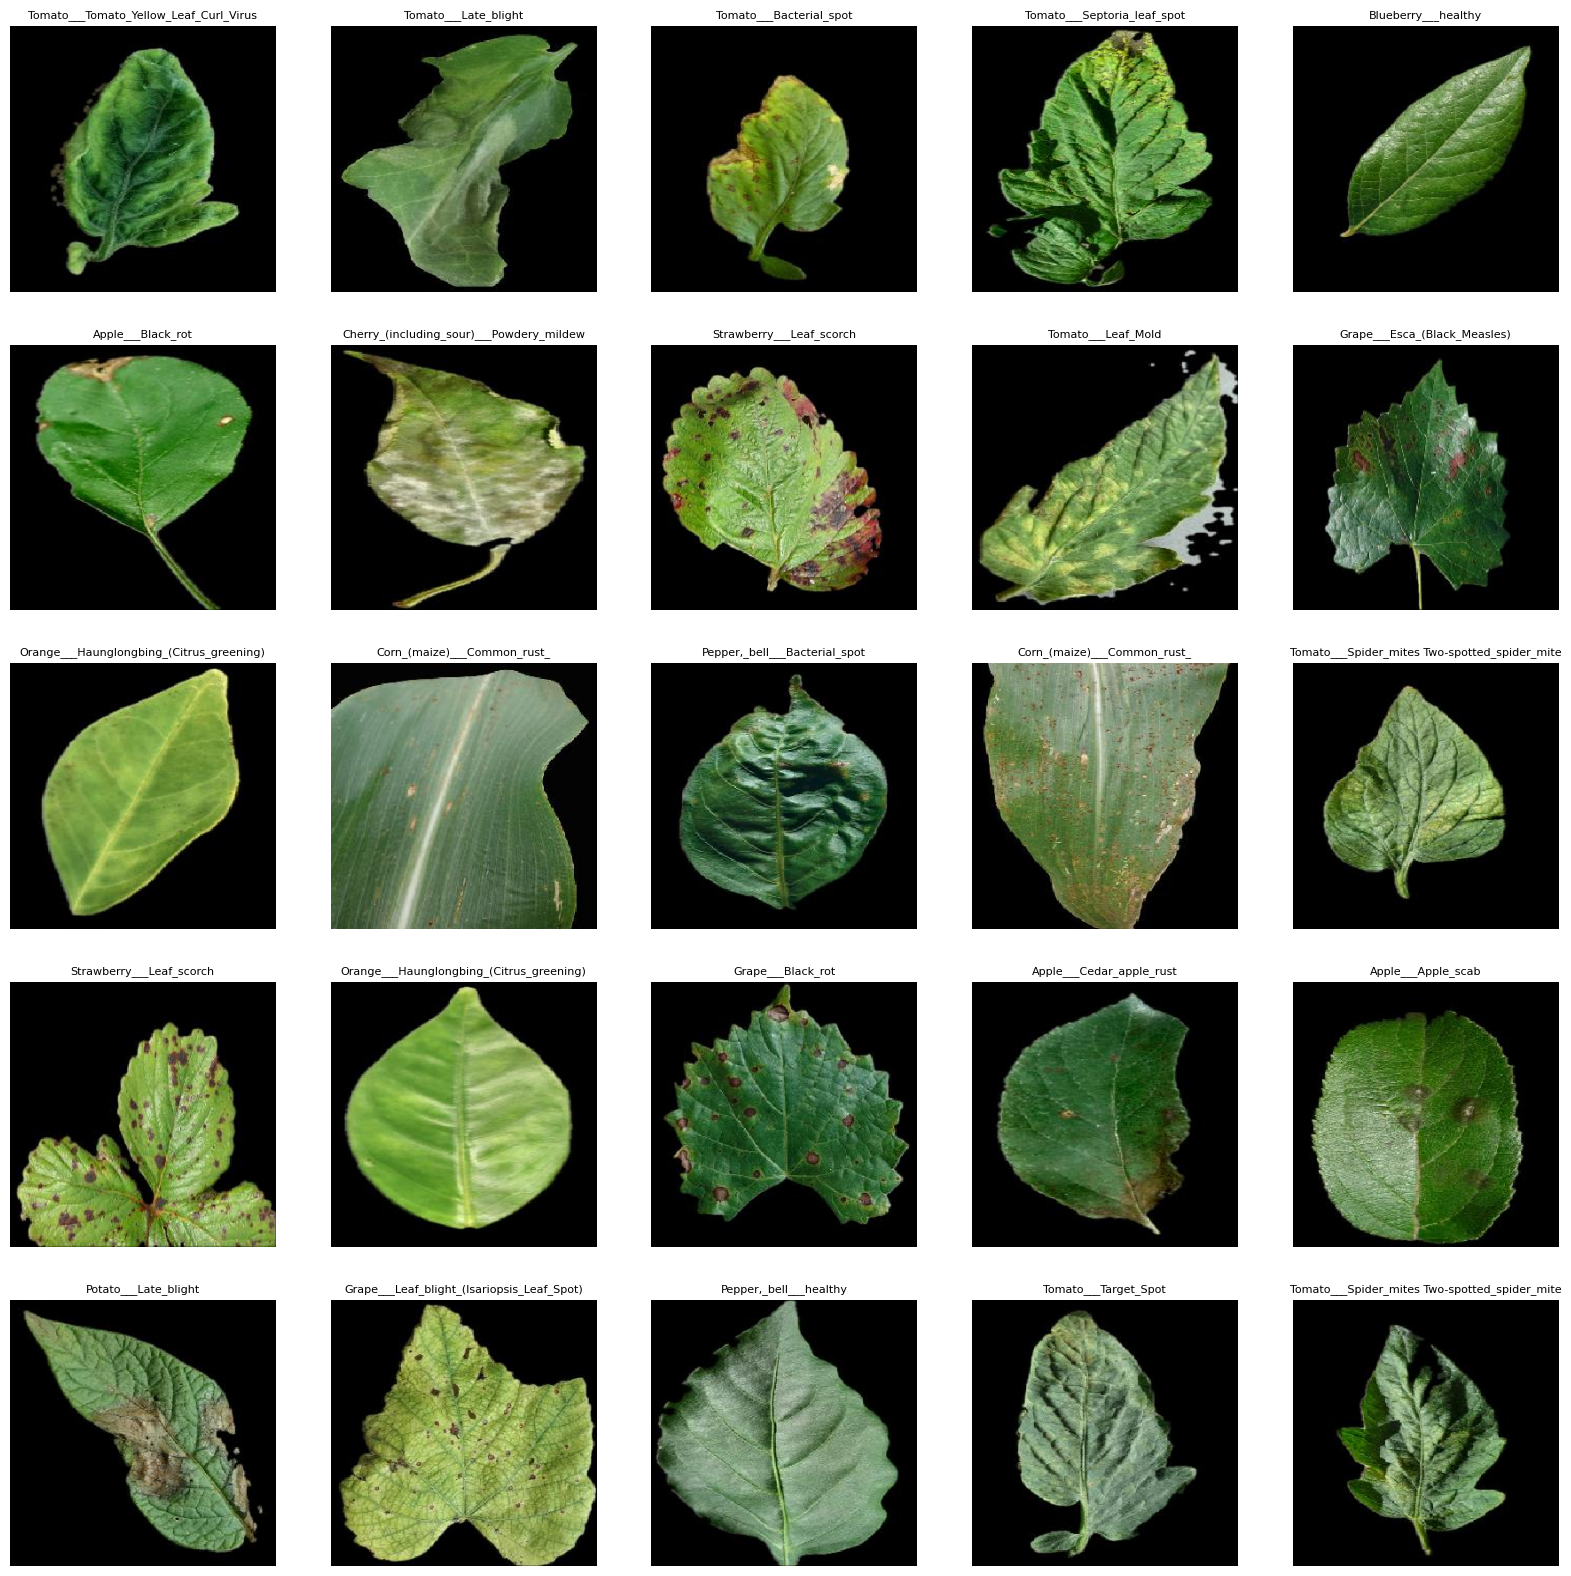

In [11]:
#Calling function to display images
show_images(train_gen)

In [12]:
#Getting number of output classes
class_count = len(list(train_gen.class_indices.keys()))

In [13]:
#Defining pretrained model ,  Model used - EfficientNetB3
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= (300,300,3), pooling= 'max')

In [14]:
#Using model's trained parameters without changing it
for layer in base_model.layers:
    layer.trainable = False

In [15]:
#Creating model
new_model = Sequential()
new_model.add(base_model)
new_model.add(Flatten())
new_model.add(BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001))
new_model.add(Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                activation= 'relu'))
new_model.add(Dropout(rate= 0.45, seed= 123))
new_model.add(Dense(class_count, activation= 'softmax'))


In [16]:
new_model.compile(loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(0.0005),metrics=['accuracy'])

In [17]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 38)                9766      
                                                        

In [18]:
#Set callback parameter , saving best parameter in final_model_weights1.hdf5
checkpointer = [tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', verbose = 1, restore_best_weights=True, mode="max",patience = 10),
                tf.keras.callbacks.ModelCheckpoint(
                    filepath='final_model_weights1.hdf5',
                    monitor="val_accuracy",
                    verbose=1,
                    save_best_only=True,
                    mode="max")]

In [19]:
#implement earlystopping
steps_per_epoch = train_gen.n // train_gen.batch_size
validation_steps = valid_gen.n // valid_gen.batch_size
history = new_model.fit(x=train_gen,
                 validation_data=valid_gen,
                 epochs=25,
                 callbacks=[checkpointer],
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps,shuffle = False)

Epoch 1/25
1086/1086 [==============================] - ETA: 0s - loss: 3.3694 - accuracy: 0.7663
Epoch 1: val_accuracy improved from -inf to 0.91167, saving model to final_model_weights1.hdf5
1086/1086 [==============================] - 333s 294ms/step - loss: 3.3694 - accuracy: 0.7663 - val_loss: 1.1758 - val_accuracy: 0.9117
Epoch 2/25
1086/1086 [==============================] - ETA: 0s - loss: 1.3128 - accuracy: 0.8383
Epoch 2: val_accuracy did not improve from 0.91167
1086/1086 [==============================] - 317s 291ms/step - loss: 1.3128 - accuracy: 0.8383 - val_loss: 1.0392 - val_accuracy: 0.9037
Epoch 3/25
1086/1086 [==============================] - ETA: 0s - loss: 1.2198 - accuracy: 0.8411
Epoch 3: val_accuracy did not improve from 0.91167
1086/1086 [==============================] - 317s 292ms/step - loss: 1.2198 - accuracy: 0.8411 - val_loss: 0.9639 - val_accuracy: 0.9104
Epoch 4/25
1086/1086 [==============================] - ETA: 0s - loss: 1.1527 - accuracy: 0.8473


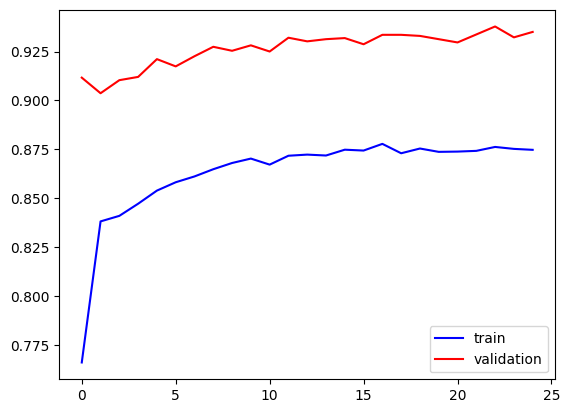

In [20]:
#plottting accuracy curve for training and validation data
py.plot(history.history['accuracy'],color='blue',label='train')
py.plot(history.history['val_accuracy'],color='red',label='validation')
py.legend()
py.show()

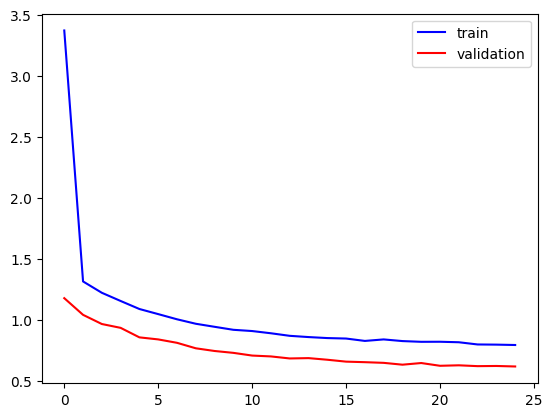

In [21]:
#plottting loss curve for training and validation data
py.plot(history.history['loss'],color='blue',label='train')
py.plot(history.history['val_loss'],color='red',label='validation')
py.legend()
py.show()

In [22]:
#Evaluate model
test_batch  = 32;
train_eval = new_model.evaluate(train_gen,steps = test_batch,verbose=1) #checking for loss and accuracy for training data
val_eval = new_model.evaluate(valid_gen,steps = test_batch,verbose=1)#checking for loss and accuracy for validation data
test_eval = new_model.evaluate(test_gen,steps = test_batch,verbose=1)#checking for loss and accuracy for testing data
print("Train Loss: ", round(train_eval[0]*100,2))
print("Train Accuracy: ", round(train_eval[1]*100,2))
print('-' * 20)
print("Validation Loss: ", round(val_eval[0]*100,2))
print("Validation Accuracy: ", round(val_eval[1]*100,2))
print('-' * 20)
print("Test Loss: ", round(test_eval[0]*100,2))
print("Test Accuracy: ",round(test_eval[1]*100,2))

32/32 [==============================] - 2s 31ms/step - loss: 0.5886 - accuracy: 0.9062
Train Loss:  56.61
Train Accuracy:  94.45
--------------------
Validation Loss:  64.01
Validation Accuracy:  92.81
--------------------
Test Loss:  58.86
Test Accuracy:  90.62


In [23]:
#Making Predictions
preds = new_model.predict(test_gen)

# print(y_pred)

5431/5431 [==============================] - 131s 24ms/step


In [24]:
preds

array([[1.9119880e-06, 3.4359953e-05, 4.1006638e-06, ..., 7.6355482e-06,
        5.6012770e-08, 4.0524506e-07],
       [7.3021250e-03, 1.3711766e-03, 2.3203040e-04, ..., 7.4068312e-06,
        9.9436306e-07, 4.5566112e-04],
       [8.1716873e-09, 5.0320835e-07, 2.6801228e-09, ..., 1.4233528e-10,
        1.6402591e-12, 2.1005743e-08],
       ...,
       [2.6378550e-06, 5.1011857e-06, 1.4488702e-06, ..., 4.0145314e-04,
        3.1183966e-04, 3.3854409e-05],
       [5.6193511e-07, 2.3175794e-06, 1.3924466e-05, ..., 4.4539192e-08,
        2.6111820e-08, 3.4301610e-08],
       [1.1772124e-04, 9.9823868e-01, 1.1602181e-03, ..., 7.2394024e-09,
        3.3138756e-10, 1.4577847e-08]], dtype=float32)

In [25]:
a = np.argmax(preds, axis=1)

In [29]:
a

array([15,  3, 24, ..., 32, 12,  1])

In [30]:
test_labels = test_gen.classes

In [32]:
#checking accuracy score for test generators
accuracy_score(test_labels,a)

0.9355551463818818

In [34]:
test_labels[2]

24

In [36]:
#Saving Model
new_model.save('Plant_Detection_model_final.h5')

In [105]:
#Loading saved model
model = load_model('Plant_Detection_model_final.h5')

In [106]:
img_path = 'test2.jpeg' #storing path of img to be predicted

In [107]:
img = load_img(img_path,target_size = (300,300))

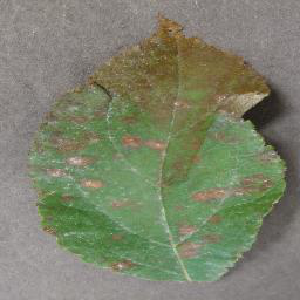

In [108]:
img

In [109]:
x = img_to_array(img) #converting image to array

In [110]:
x = np.expand_dims(x,axis=0) #expanding dimension of image to 4D array (batch_size,img_height,img_width,channels)

In [111]:
x

array([[[[127., 122., 118.],
         [155., 150., 146.],
         [150., 145., 141.],
         ...,
         [130., 125., 122.],
         [132., 127., 124.],
         [135., 130., 127.]],

        [[145., 140., 136.],
         [154., 149., 145.],
         [147., 142., 138.],
         ...,
         [142., 137., 134.],
         [141., 136., 133.],
         [140., 135., 132.]],

        [[154., 149., 145.],
         [145., 140., 136.],
         [137., 132., 128.],
         ...,
         [147., 142., 139.],
         [144., 139., 136.],
         [141., 136., 133.]],

        ...,

        [[165., 161., 162.],
         [164., 160., 161.],
         [164., 160., 161.],
         ...,
         [127., 123., 122.],
         [126., 122., 121.],
         [125., 121., 120.]],

        [[163., 159., 160.],
         [162., 158., 159.],
         [162., 158., 159.],
         ...,
         [127., 123., 122.],
         [126., 122., 121.],
         [125., 121., 120.]],

        [[159., 155., 156.],
       

In [112]:
x

array([[[[127., 122., 118.],
         [155., 150., 146.],
         [150., 145., 141.],
         ...,
         [130., 125., 122.],
         [132., 127., 124.],
         [135., 130., 127.]],

        [[145., 140., 136.],
         [154., 149., 145.],
         [147., 142., 138.],
         ...,
         [142., 137., 134.],
         [141., 136., 133.],
         [140., 135., 132.]],

        [[154., 149., 145.],
         [145., 140., 136.],
         [137., 132., 128.],
         ...,
         [147., 142., 139.],
         [144., 139., 136.],
         [141., 136., 133.]],

        ...,

        [[165., 161., 162.],
         [164., 160., 161.],
         [164., 160., 161.],
         ...,
         [127., 123., 122.],
         [126., 122., 121.],
         [125., 121., 120.]],

        [[163., 159., 160.],
         [162., 158., 159.],
         [162., 158., 159.],
         ...,
         [127., 123., 122.],
         [126., 122., 121.],
         [125., 121., 120.]],

        [[159., 155., 156.],
       

In [113]:
pred = model.predict(x) #predicting the new image

1/1 [==============================] - 2s 2s/step


In [114]:
pred

array([[3.2569657e-03, 9.2653401e-02, 7.8509760e-01, 3.8733808e-04,
        4.9926853e-04, 3.8274698e-04, 7.0490513e-04, 1.8385920e-04,
        5.1619200e-04, 1.3471775e-04, 8.0288164e-06, 2.2757645e-03,
        1.3632754e-02, 1.3523365e-04, 1.7533755e-05, 1.7626857e-03,
        1.5521393e-02, 7.0380083e-06, 4.3421604e-02, 1.3382408e-04,
        2.0679003e-02, 1.2290641e-03, 8.2429636e-07, 1.1819132e-05,
        9.1928197e-04, 2.8534640e-05, 3.9144242e-03, 4.1037188e-06,
        6.0674176e-03, 8.0480316e-04, 1.4682990e-03, 1.3236384e-05,
        3.8704583e-03, 3.6729009e-05, 1.4457198e-04, 2.7547376e-05,
        6.1372748e-07, 4.6140340e-05]], dtype=float32)

In [115]:
p = np.argmax(pred) 

In [3]:
p

In [4]:
def predict_class(pred_number):
    class_name = "Empty"
    if(pred_number == 0): class_name = "Apple___Apple_scab"
    elif(pred_number == 1): class_name = "Apple___Black_rot"
    elif(pred_number == 2): class_name = "Apple___Cedar_apple_rust"
    elif(pred_number == 3): class_name = "Apple___healthy"
    elif(pred_number == 4): class_name = "Blueberry___healthy"
    elif(pred_number == 5): class_name = "Cherry_(including_sour)___Powdery_mildew"
    elif(pred_number == 6): class_name = "Cherry_(including_sour)___healthy"
    elif(pred_number == 7): class_name = "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot"
    elif(pred_number == 8): class_name = "Corn_(maize)___Common_rust_"
    elif(pred_number == 9): class_name = "Corn_(maize)___Northern_Leaf_Blight"
    elif(pred_number == 10): class_name = "Corn_(maize)___healthy"
    elif(pred_number == 11): class_name = "Grape___Black_rot"
    elif(pred_number == 12): class_name = "Grape___Esca_(Black_Measles)"
    elif(pred_number == 13): class_name = "Grape___Leaf_blight_(Isariopsis_Leaf_Spot)"
    elif(pred_number == 14): class_name = "Grape___healthy"
    elif(pred_number == 15): class_name = "Orange___Haunglongbing_(Citrus_greening)"
    elif(pred_number == 16): class_name = "Peach___Bacterial_spot"
    elif(pred_number == 17): class_name = "Peach___healthy"
    elif(pred_number == 18): class_name = "Pepper,_bell___Bacterial_spot"
    elif(pred_number == 19): class_name = "Pepper,_bell___healthy"
    elif(pred_number == 20): class_name = "Potato___Early_blight"
    elif(pred_number == 21): class_name = "Potato___Late_blight"
    elif(pred_number == 22): class_name = "Potato___healthy"
    elif(pred_number == 23): class_name = "Raspberry___healthy"
    elif(pred_number == 24): class_name = "Soybean___healthy"
    elif(pred_number == 25): class_name = "Squash___Powdery_mildew"
    elif(pred_number == 26): class_name = "Strawberry___Leaf_scorch"
    elif(pred_number == 27): class_name = "Strawberry___healthy"
    elif(pred_number == 28): class_name = "Tomato___Bacterial_spot"
    elif(pred_number == 29): class_name = "Tomato___Early_blight"
    elif(pred_number == 30): class_name = "Tomato___Late_blight"
    elif(pred_number == 31): class_name = "Tomato___Leaf_Mold"
    elif(pred_number == 32): class_name = "Tomato___Septoria_leaf_spot"
    elif(pred_number == 33): class_name = "Tomato___Spider_mites Two-spotted_spider_mite"
    elif(pred_number == 34): class_name = "Tomato___Target_Spot"
    elif(pred_number == 35): class_name = "Tomato___Tomato_Yellow_Leaf_Curl_Virus"
    elif(pred_number == 36): class_name = "Tomato___Tomato_mosaic_virus"
    elif(pred_number == 37): class_name = "Tomato___healthy"
    return class_name

In [6]:
className = predict_class(p)

In [7]:
className

'Apple___Cedar_apple_rust'